# [ 전체적인 흐름 설명 ]
- 시간흐름에 따른 특징을 반영하기 위해서 날짜와 관련된 변수들을 추가하여 LSTM을 사용함.
- 이후 EDA를 통해 공휴일에는 전체적으로 값이 낮아지는 것을 확인하고 LSTM모델링 시, 공휴일에 가중치를 부여함.
- 같은 달 내에 존재하는 평일 및 휴일이 선명하게 나뉘는 것을 확인함. 또한 같은 달의 평일끼리는 비슷한 값을 가지며 휴일 또한 마찬가지임을 확인함.
- 이와같은 안정적인 패턴을 반영하기 위해 휴일, 평일로 나누고 보다 정확한 예측을 위해 대회 개수에 따라 한번 더 분리함.
- 정형화된 패턴이 없는 날의 특징을 찾기 위해 추가 데이터 분석. 이를 통해 추가 데이터로부터 로그인 수, 제출 수를 파악하고 해당 데이터로부터 실제 로그인한 수, 총 로그인 한 수 등의 정보를 따로 파악하여 새로운 피처셋 구성
- 위와 같은 다양한 분석 및 모델링 과정을 통해 결과 값이 극단적인 패턴을 보여야 한다고 판단. 그래서 조금 더 유연한 결과를 갖는 xgb와 lstm의 결과와 극단적인 패턴을 보이는 extra의 결과를 Weighted average Ensemble을 통해 최종 결과를 도출함.

# [ 목차 ]
1. 라이브러리 및 데이터 불러오기
2. 추가 데이터 처리
3. EDA
4. LSTM
5. XGBoost
6. Extra Tree
7. Weighted average Ensemble

# 1. 라이브러리 및 데이터 불러오기

In [96]:
import pandas as pd
from numpy import asarray
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
import pandas_datareader.data as pdr
import numpy as np
from xgboost import plot_importance, plot_tree
from numpy import asarray
from math import sqrt
from matplotlib import pyplot
from datetime import date

import warnings
import matplotlib.pyplot as plt
import matplotlib
import plotly.graph_objects as go
import chart_studio.plotly as py
import plotly.offline as pyo
import plotly.io as pio
from plotly.subplots import make_subplots
import matplotlib as mpl   
import matplotlib.font_manager as fm
import seaborn as sns
plt.style.use('ggplot')
%matplotlib inline
plt.rcParams['font.family']='NanumGothic'
pio.renderers.default = 'notebook_connected'
print(plt.rcParams['font.family'])

from xgboost import XGBRegressor
from sklearn.ensemble import ExtraTreesRegressor
import category_encoders as ce
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential
from tensorflow.keras.layers import Dense, Conv1D, LSTM, Input, TimeDistributed
from tensorflow.keras.models import Model

print(tf.__version__)
print(keras.__version__)

warnings.filterwarnings(action='ignore')

['NanumGothic']
2.3.0
2.4.0


In [97]:
## 데이터 불러오기
train = pd.read_csv("data/train.csv", encoding = 'euc-kr')
train['DateTime'] = pd.to_datetime(train['DateTime'])
train['date'] = train.DateTime.dt.date

new_train= pd.read_csv("data/2차_train.csv", encoding = 'euc-kr')
new_train['DateTime'] = pd.to_datetime(new_train['DateTime'])
new_train['date'] = new_train.DateTime.dt.date

## 시간 합산
train = pd.DataFrame(train.groupby('date').sum().reset_index())
new_train = pd.DataFrame(new_train.groupby('date').sum().reset_index())

## 1차 train과 2차 train 합치기
train = pd.concat([train, new_train]).reset_index(drop = True)
train_data = train.copy()

## submission 데이터
submission = pd.read_csv('data/submission.csv', encoding = 'euc-kr')
submission.DateTime = pd.to_datetime(submission.DateTime).dt.date
submission = submission[submission.DateTime>date(2020,12,8)].reset_index(drop = True)

# 2. 추가 데이터 처리

In [98]:
login_info = pd.read_csv('data/new_login_info.csv', index_col=0)
competition_info = pd.read_csv('data/new_competition_info.csv', index_col=0, encoding='cp949')
user_info = pd.read_csv('data/new_user_info.csv', index_col=0)
submission_info = pd.read_csv('data/new_submission_info.csv', index_col=0).dropna(how = 'all')

In [99]:
## active_made
## id와 c_time만 남김
made_info = user_info[['id','c_time']]

## c_time과 id 모두 같은 곳에서 결측치기에 모두 삭제
made_info_dropna = made_info.dropna().copy()
made_info_dropna['c_time'] = pd.to_datetime(made_info_dropna['c_time'])

# 연월일로 나타내기
made_info_dropna['day'] = made_info_dropna['c_time'].apply(lambda x : x.strftime('%Y-%m-%d') )
made_info_dropna.day = pd.to_datetime(made_info_dropna.day).dt.date
made_info_dropna = made_info_dropna[made_info_dropna.day>=date(2018,9,9)].reset_index(drop = True)

# 아이디 생성한 사용자
active_made = made_info_dropna.groupby(['day'])['id'].nunique().reset_index()
active_made.day = pd.to_datetime(active_made.day).dt.date
active_made.rename(columns = {'id':'active_made'}, inplace = True)


### active_login_user
## user_id와 c_time 변수를 제외한 나머지 모든 변수 제거
## 중간중간 있는 login_id나 user_id의 결측치도 모두 제거
login_info_drop_na = login_info[['user_id','c_time']].dropna().copy()
login_info_drop_na['c_time'] = pd.to_datetime(login_info_drop_na['c_time'])
## 연월일로 나타내기
login_info_drop_na['day'] = login_info_drop_na['c_time'].apply(lambda x : x.strftime('%Y-%m-%d') )
## 실제 로그인한 사용자가 몇 명인가
active_login_user = login_info_drop_na.groupby(['day'])['user_id'].nunique().reset_index()
active_login_user['day'] = pd.to_datetime(active_login_user['day']).dt.date
active_login_user.rename(columns = {'user_id':'active_login_user'}, inplace = True)


### all_login_user
## platform과 browser의 결측치가 많아 변수 제거 -> 유의미한 변수도 아님
## 중간중간 있는 login_id나 user_id의 결측치도 모두 제거
login_info_drop_na2 = login_info[['user_id','c_time']].copy()
## 총 사용자를 확인 하기 위해 결측치 다 채우기
login_info_drop_na2['user_id'].fillna(0, inplace = True)
login_info_drop_na2 = login_info_drop_na2.dropna()
login_info_drop_na2['c_time'] = pd.to_datetime(login_info_drop_na2['c_time'])
## 연월일로 나타내기
login_info_drop_na2['day'] = login_info_drop_na2['c_time'].apply(lambda x : x.strftime('%Y-%m-%d') )
## 해당 일에 로그인 횟수가 총 몇 번인가
all_login_user = login_info_drop_na2.groupby(['day'])['user_id'].count().reset_index()
all_login_user['day'] = pd.to_datetime(all_login_user['day']).dt.date
all_login_user.rename(columns = {'user_id':'all_login_user'}, inplace = True)


## team_id별 user_id별 제출 수 뽑기
sub_info = submission_info.copy()
sub_info_dropna = sub_info[['team_id','user_id','c_time']].dropna().copy()
sub_info_dropna.c_time = pd.to_datetime(sub_info_dropna.c_time)
# 연월로 나타내기
sub_info_dropna['day'] = sub_info_dropna['c_time'].apply(lambda x : x.strftime('%Y-%m-%d') )
sub_info_dropna = sub_info_dropna[(sub_info_dropna['day']>='2018-09-09')]


## 실제 제출한 사용자가 몇 명인가 : user_id
active_sub_user = sub_info_dropna.groupby(['day'])['user_id'].nunique().reset_index()
active_sub_user.day = pd.to_datetime(active_sub_user.day).dt.date
active_sub_user.rename(columns = {'user_id':'active_sub_user'}, inplace = True)

## 팀 아이디로 정리 : 
active_sub_team = sub_info_dropna.groupby(['day'])['team_id'].nunique().reset_index()
active_sub_team.day = pd.to_datetime(active_sub_team.day).dt.date
active_sub_team.rename(columns = {'team_id':'active_sub_team'}, inplace = True)

### team_id별 user_id별 제출 수 뽑기
sub_info = submission_info.copy()
sub_info_all = sub_info[['team_id','user_id','c_time']]
sub_info_all.c_time = pd.to_datetime(sub_info_all.c_time)
sub_info_all[['team_id','user_id']] = sub_info_all[['team_id','user_id']].fillna(0)
sub_info_all['day'] = sub_info_all['c_time'].apply(lambda x : x.strftime('%Y-%m-%d') )
sub_info_all = sub_info_all[(sub_info_all['day']>='2018-09-09')]

## 제출한 총 수
all_sub_user = sub_info_all.groupby(['day'])['user_id'].count().reset_index()
all_sub_user.day = pd.to_datetime(all_sub_user.day).dt.date
all_sub_user.rename(columns = {'user_id':'all_sub_user'}, inplace = True)

## 팀 아이디로 제출한 총 수
all_sub_team = sub_info_all.groupby(['day'])['team_id'].count().reset_index()
all_sub_team.day = pd.to_datetime(all_sub_team.day).dt.date
all_sub_team.rename(columns = {'team_id':'all_sub_team'}, inplace = True)

In [100]:
## 제출수 요일이 가장 적으므로 '제출'을 기준으로 병합
print(active_made.shape)
print(active_login_user.shape)
print(all_login_user.shape)
print(active_sub_user.shape)
print(active_sub_team.shape)
print(all_sub_user.shape)
print(all_sub_team.shape)

add_data_list = [all_login_user, active_sub_user, active_sub_team, all_sub_user, all_sub_team]
add_data = pd.merge(active_made, active_login_user, how = 'inner', on = 'day')
for i in add_data_list:
    add_data = pd.merge(add_data, i, how = 'inner', on = 'day')
    
add_data = add_data.rename(columns = {'day':'date'})
add_data.tail()

(842, 2)
(839, 2)
(839, 2)
(779, 2)
(779, 2)
(779, 2)
(779, 2)


,date,active_made,active_login_user,all_login_user,active_sub_user,active_sub_team,all_sub_user,all_sub_team
752,2021-01-04,117,387,477,129,118,283,283
753,2021-01-05,101,365,453,131,120,268,268
754,2021-01-06,100,555,639,197,178,430,430
755,2021-01-07,81,420,480,197,174,412,412
756,2021-01-08,82,358,449,205,178,408,408


# 3. EDA

#### 1) 전체적인 시각화

In [101]:
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=("User","Session","Page view","New User"), horizontal_spacing=0.08, vertical_spacing=0.08
)
fig.add_trace(go.Scatter(x=train['date'], y=train['사용자'],name="User",showlegend=False, ), row=1, col=1)
fig.add_trace(go.Scatter(x=train['date'], y=train['세션'],name="Session",showlegend=False), row=1, col=2)
fig.add_trace(go.Scatter(x=train['date'], y=train['페이지뷰'],name="Page view",showlegend=False), row=2, col=1)
fig.add_trace(go.Scatter(x=train['date'], y=train['신규방문자'],name="New User",showlegend=False), row=2, col=2)
fig.update_layout(height =700, width =1000, title_text="Scatter Plot for train", template='ggplot2')
fig.show()

In [102]:
### 보다 세부적으로 확인
fig = go.Figure()

fig.add_trace(
    go.Scatter(x=list(train.date), y=list(train.사용자),
              name='User'))
fig.add_trace(
    go.Scatter(x=list(train.date), y=list(train.세션),
              name='Session'))
fig.add_trace(
    go.Scatter(x=list(train.date), y=list(train.페이지뷰),
              name='Page veiw'))
fig.add_trace(
    go.Scatter(x=list(train.date), y=list(train.신규방문자),
              name='New User'))

# Set title
fig.update_layout(
    title_text="Overal Time series with Data"
)

# Add range slider
fig.update_layout(
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label="1m",
                     step="month",
                     stepmode="backward"),
                dict(count=6,
                     label="6m",
                     step="month",
                     stepmode="backward"),
                dict(count=1,
                     label="YTD",
                     step="year",
                     stepmode="todate"),
                dict(count=1,
                     label="1y",
                     step="year",
                     stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(
            visible=True
        ),
        type="date"
    )
)
fig.update_layout(template='ggplot2')
fig.show()

#### 2) 연도별 시각화

In [103]:
### 연도별 Y의 평균
## 연도만 뽑기
train['year'] = train['date'].apply(lambda x : x.strftime('%Y'))

year_train = train.groupby(['year'])[['사용자','세션','신규방문자','페이지뷰']].mean().reset_index()
year_train.head()

,year,사용자,세션,신규방문자,페이지뷰
0,2018,206.947368,204.780702,63.000000,1618.482456
1,2019,506.819178,524.487671,159.430137,6284.134247
2,2020,2216.682216,2172.446064,498.209913,55868.854227


In [104]:
fig = make_subplots(
    rows=1, cols=4,
    subplot_titles=("train User","train Sess","train Page ","train New"), horizontal_spacing=0.05
)
fig.add_trace(go.Scatter(x=year_train['year'], y=year_train['사용자'],name="User",showlegend=False, ), row=1, col=1)
fig.add_trace(go.Scatter(x=year_train['year'], y=year_train['세션'],name="Session",showlegend=False), row=1, col=2)
fig.add_trace(go.Scatter(x=year_train['year'], y=year_train['페이지뷰'],name="Page view",showlegend=False), row=1, col=3)
fig.add_trace(go.Scatter(x=year_train['year'], y=year_train['신규방문자'],name="New User",showlegend=False), row=1, col=4)
fig.update_layout( title_text="Trend by year", template='ggplot2')
fig.show()

#### 3) 월별 시각화

In [105]:
### 연도별 Y의 평균
## 연도만 뽑기
train['month'] = train['date'].apply(lambda x : x.strftime('%Y-%m'))

year_train = train.groupby(['month'])[['사용자','세션','신규방문자','페이지뷰']].mean().reset_index()
year_train.head()

,month,사용자,세션,신규방문자,페이지뷰
0,2018-09,226.409091,213.409091,47.227273,1615.590909
1,2018-10,149.129032,148.774194,53.064516,909.645161
2,2018-11,222.233333,226.066667,84.033333,1704.900000
3,2018-12,236.161290,234.064516,63.774194,2245.741935
4,2019-01,302.387097,300.870968,84.032258,2434.612903


In [106]:
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=("train User","train Sess","train Page ","train New"), horizontal_spacing=0.07,vertical_spacing=0.06
)

fig.add_trace(go.Scatter(x=year_train['month'], y=year_train['사용자'],name="User",showlegend=False, ), row=1, col=1)
fig.add_trace(go.Scatter(x=year_train['month'], y=year_train['세션'],name="Session",showlegend=False), row=1, col=2)
fig.add_trace(go.Scatter(x=year_train['month'], y=year_train['페이지뷰'],name="Page view",showlegend=False), row=2, col=1)
fig.add_trace(go.Scatter(x=year_train['month'], y=year_train['신규방문자'],name="New User",showlegend=False), row=2, col=2)
fig.update_layout(height =1000, width =1000, title_text="Trend by month", template='ggplot2')
fig.show()

#### 월의 특징 파악
- 19년 12월부터 20년의 11월까지 특징 그래프.
- 12월 31일, 1월 1일이 떨어진다는 점 보이기 위함.
- 최근의 특징을 가장 많이 가지고 있는 2020년의 데이터에서 월별로 그래프를 그려보았을 때 주말 및 휴일에는 하락하고 평일에는 상승하는 점이 보임
- 특징있는 날을 제외하고서는 한달 이내 상승점들의 높이는 비슷하고 하락점 또한 비슷함.
- 공휴일과 주말이 비슷한 모습을 보임.

In [107]:
train['dayofmonth'] = pd.to_datetime(train['date']).dt.day
train['month'] = pd.to_datetime(train['date']).dt.month
train['year'] = pd.to_datetime(train['date']).dt.year

#### 사용자
#### 가장 최근 월별로 Y 분석을 해본 뒤에 월초와 월말을 어떤식으로 나눌지에 대해서 고민
# 1,2,3,4,5월 분석
train_1_20 = train[(train['month']==1) & (train['year']==2020)]
train_2_20 = train[(train['month']==2) & (train['year']==2020)]
train_3_20 = train[(train['month']==3) & (train['year']==2020)]
train_4_20 = train[(train['month']==4) & (train['year']==2020)]
train_5_20 = train[(train['month']==5) & (train['year']==2020)]
train_6_20= train[(train['month']==6) & (train['year']==2020)]

# 6,7,8,9,10월 분석
train_6_20 = train[(train['month']==6) & (train['year']==2020)]
train_7_20 = train[(train['month']==7) & (train['year']==2020)]
train_8_20 = train[(train['month']==8) & (train['year']==2020)]
train_9_20 = train[(train['month']==9) & (train['year']==2020)]
train_10_20 = train[(train['month']==10) & (train['year']==2020)]
train_11_20 = train[(train['month']==11) & (train['year']==2020)]


# 19년 5~12월 진행
train_4_19 = train[(train['month']==4) & (train['year']==2019)]
train_5_19 = train[(train['month']==5) & (train['year']==2019)]
train_6_19 = train[(train['month']==6) & (train['year']==2019)]
train_7_19 = train[(train['month']==7) & (train['year']==2019)]
train_8_19 = train[(train['month']==8) & (train['year']==2019)]
train_9_19 = train[(train['month']==9) & (train['year']==2019)]
train_10_19 = train[(train['month']==10) & (train['year']==2019)]
train_11_19 = train[(train['month']==11) & (train['year']==2019)]
train_12_19 = train[(train['month']==12) & (train['year']==2019)]

# 18년 10월 11월 12월 19년 1월 2월 4월
train_10_18 = train[(train['month']==10) & (train['year']==2018)]
train_11_18 = train[(train['month']==11) & (train['year']==2018)]
train_12_18 = train[(train['month']==12) & (train['year']==2018)]
train_1_19 = train[(train['month']==1) & (train['year']==2019)]
train_2_19 = train[(train['month']==2) & (train['year']==2019)]

- 19년 12월부터 20년의 11월까지 특징 (사용자)

In [108]:
dataset=[train_12_19, train_1_20, train_2_20, train_3_20, train_4_20, train_5_20, 
         train_6_20, train_7_20, train_8_20, train_9_20, train_10_20, train_11_20]

row=6
col=2
num=0

fig = make_subplots(
    rows=row, cols=col,
    subplot_titles=("2019 Dec","2020 Jan","2020 Feb","2020 Mar","2020 Apr","2020 May","2020 Jun", "2020 Jul", "2020 Aug",
                    "2020 Sep","2020 Oct","2020 Nov") ,horizontal_spacing=0.05, vertical_spacing=0.07 )

for i in range(row):
    for j in range(col):
            fig.add_trace(go.Scatter(x=dataset[num]['date'], y=dataset[num]['사용자'],marker=dict(size=9, color='red'),
                                     showlegend=False,name='User'),row=i+1,col=j+1)
            num+=1
            
fig.update_layout(height =1500, width =1000, title_text="User Trend by month (2019 Dec ~ 2020 Oct)", template='ggplot2')
fig.show()

- 19년 12월부터 20년의 11월까지 특징 (세션)

In [109]:
dataset=[train_12_19, train_1_20, train_2_20, train_3_20, train_4_20, train_5_20, 
         train_6_20, train_7_20, train_8_20, train_9_20, train_10_20, train_11_20]

row=6
col=2
num=0

fig = make_subplots(
    rows=row, cols=col,
    subplot_titles=("2019 Dec","2020 Jan","2020 Feb","2020 Mar","2020 Apr","2020 May","2020 Jun", "2020 Jul", "2020 Aug",
                    "2020 Sep","2020 Oct","2020 Nov") ,horizontal_spacing=0.05, vertical_spacing=0.07 )

for i in range(row):
    for j in range(col):
            fig.add_trace(go.Scatter(x=dataset[num]['date'], y=dataset[num]['세션'],marker=dict(size=9, color='Blue'),
                                     showlegend=False, name='Session'),row=i+1,col=j+1)
            num+=1
            
fig.update_layout(height =1500, width =1000, title_text="Session Trend by month (2019 Dec ~ 2020 Oct)", template='ggplot2')
fig.show()

- 19년 12월부터 20년의 11월까지 특징 (신규방문자)

In [110]:
dataset=[train_12_19, train_1_20, train_2_20, train_3_20, train_4_20, train_5_20, 
         train_6_20, train_7_20, train_8_20, train_9_20, train_10_20, train_11_20]

row=6
col=2
num=0

fig = make_subplots(
    rows=row, cols=col,
    subplot_titles=("2019 Dec","2020 Jan","2020 Feb","2020 Mar","2020 Apr","2020 May","2020 Jun", "2020 Jul", "2020 Aug",
                    "2020 Sep","2020 Oct","2020 Nov") ,horizontal_spacing=0.05, vertical_spacing=0.07 )
for i in range(row):
    for j in range(col):
            fig.add_trace(go.Scatter(x=dataset[num]['date'], y=dataset[num]['신규방문자'],marker=dict(size=9, color='Purple'),
                                     showlegend=False, name='New User'),row=i+1,col=j+1)
            num+=1
            
fig.update_layout(height =1500, width =1000, title_text="New User Trend by month (2019 Dec ~ 2020 Oct)", template='ggplot2')
fig.show()

- 19년 12월부터 20년의 11월까지 특징 (페이지뷰)

In [111]:
dataset=[train_12_19, train_1_20, train_2_20, train_3_20, train_4_20, train_5_20, 
         train_6_20, train_7_20, train_8_20, train_9_20, train_10_20, train_11_20]

row=6
col=2
num=0

fig = make_subplots(
    rows=row, cols=col,
    subplot_titles=("2019 Dec","2020 Jan","2020 Feb","2020 Mar","2020 Apr","2020 May","2020 Jun", "2020 Jul", "2020 Aug",
                    "2020 Sep","2020 Oct","2020 Nov") ,horizontal_spacing=0.05, vertical_spacing=0.07 )
for i in range(row):
    for j in range(col):
            fig.add_trace(go.Scatter(x=dataset[num]['date'], y=dataset[num]['페이지뷰'],marker=dict(size=9, color='Green'),
                                     showlegend=False,name='Page view'),row=i+1,col=j+1)
            num+=1
            
fig.update_layout(height =1500, width =1000, title_text="Page view Trend by month (2019 Dec ~ 2020 Oct)", template='ggplot2')
fig.show()

#### 연휴 기간
- 연휴 기간에도 휴일과 같이 하락한 모습을 보임
- 20년 5월의 연휴 확인
- 19년 12월 31일 연말 모습 확인
- 18년 12/31, 19년 12/31, 추가 데이터의 제출 수, 로그인 수, 아이디 생성 수 등을 시각화로 보이기

In [124]:
## 18년과 19년 12/31 ~ 1/1
train_later_18 = train[(train['date']>=date(2018, 12, 23))&(train['date']<=date(2019, 1, 5))]
train_later_19 = train[(train['date']>=date(2019, 12, 23))&(train['date']<=date(2020, 1, 5))]

## 추가데이터 12/31 ~ 1/1
add_later18 = add_data[(add_data['date']>=date(2018, 12, 20))&(add_data['date']<=date(2019, 1, 5))]
add_later19 = add_data[(add_data['date']>=date(2019, 12, 20))&(add_data['date']<=date(2020, 1, 5))]

In [126]:
## train 데이터의 연말 연초(사용자, 세션, 신규방문자)

fig = make_subplots(
    subplot_titles=("2018.12.23 ~ 2019.1.5", "2019.12.23 ~ 2020.1.5"),
    horizontal_spacing=0.07,
    rows=1, cols=2 )

fig.add_trace(go.Scatter(x=train_later_18['date'], y=train_later_18['사용자'],name="User",
                         marker=dict(size=9, color='Red')), row=1, col=1)
fig.add_trace(go.Scatter(x=train_later_18['date'], y=train_later_18['세션'],name="Session",
                         marker=dict(size=9, color='Green')), row=1, col=1)
fig.add_trace(go.Scatter(x=train_later_18['date'], y=train_later_18['신규방문자'],name="New User",
                         marker=dict(size=9, color='Blue')), row=1, col=1)

fig.add_trace(go.Scatter(x=train_later_19['date'], y=train_later_19['사용자'],name="User",
                         marker=dict(size=9, color='Red'),showlegend=False), row=1, col=2)
fig.add_trace(go.Scatter(x=train_later_19['date'], y=train_later_19['세션'],name="Session",
                         marker=dict(size=9, color='Green'),showlegend=False), row=1, col=2)
fig.add_trace(go.Scatter(x=train_later_19['date'], y=train_later_19['신규방문자'],name="New User",
                         marker=dict(size=9, color='Blue'),showlegend=False), row=1, col=2)
fig.update_layout(title_text="Trend by End to Beginning Year (User, Session, New User)", template='ggplot2')
fig.show()



## train 연말 연초 (페이지뷰)
fig_2 = make_subplots(
    subplot_titles=("2018.12.23 ~ 2019.1.5", "2019.12.23 ~ 2020.1.5"),
    horizontal_spacing=0.07,
    rows=1, cols=2,
)

fig_2.add_trace(go.Scatter(x=train_later_18['date'], y=train_later_18['페이지뷰'],name="Page view",
                         marker=dict(size=7, color='Purple')), row=1, col=1)
fig_2.add_trace(go.Scatter(x=train_later_19['date'], y=train_later_19['페이지뷰'],name="Page view",
                         marker=dict(size=7, color='Purple'),showlegend=False), row=1, col=2)
fig_2.update_layout(title_text="Trend by End to Beginning Year (Page view)", template='ggplot2')
fig_2.show()

- 신규 아이디 생성자(active_made)와 실제 팀, 사용자 제출 수는 18년 연말 모두 하락세
- 전체적으로 수치가 낮으나 크리스마스와 1월 1일이 가장 낮은 것을 알 수 있음.
- 평일에 비해 크리스마스, 주말, 12월 31일은 모두 낮은 모습을 보임

In [120]:
## train 데이터의 연말 연초(사용자, 세션, 신규방문자)
fig = make_subplots(
    subplot_titles=("2018.12.23 ~ 2019.1.5", "2019.12.23 ~ 2020.1.5"),
    horizontal_spacing=0.07,
    rows=1, cols=2 )

fig.add_trace(go.Scatter(x=add_later18['date'], y=add_later18['active_made'],name="active_made",
                         marker=dict(size=9, color='Red')), row=1, col=1)
fig.add_trace(go.Scatter(x=add_later18['date'], y=add_later18['all_login_user'],name="all_login_user",
                         marker=dict(size=9, color='Purple')), row=1, col=1)
fig.add_trace(go.Scatter(x=add_later18['date'], y=add_later18['active_sub_user'],name="active_sub_user",
                         marker=dict(size=9, color='Orange')), row=1, col=1)
fig.add_trace(go.Scatter(x=add_later18['date'], y=add_later18['active_sub_team'],name="active_sub_team",
                         marker=dict(size=9, color='Black')), row=1, col=1)
fig.add_trace(go.Scatter(x=add_later18['date'], y=add_later18['all_sub_user'],name="all_sub_user",
                         marker=dict(size=9, color='Green')), row=1, col=1)


fig.add_trace(go.Scatter(x=add_later19['date'], y=add_later19['active_made'],name="active_made",
                         marker=dict(size=7, color='Red'), showlegend=False), row=1, col=2)
fig.add_trace(go.Scatter(x=add_later19['date'], y=add_later19['all_login_user'],name="all_login_user",
                         marker=dict(size=7, color='Purple'), showlegend=False), row=1, col=2)
fig.add_trace(go.Scatter(x=add_later19['date'], y=add_later19['active_sub_user'],name="active_sub_user",
                         marker=dict(size=7, color='Orange'), showlegend=False), row=1, col=2)
fig.add_trace(go.Scatter(x=add_later19['date'], y=add_later19['active_sub_team'],name="active_sub_team",
                         marker=dict(size=7, color='Black'), showlegend=False), row=1, col=2)
fig.add_trace(go.Scatter(x=add_later19['date'], y=add_later19['all_sub_user'],name="all_sub_user",
                         marker=dict(size=7, color='Green'), showlegend=False), row=1, col=2)


fig.update_layout(title_text="Trend by End to Beginning Year (user info)", template='ggplot2')
fig.show()

------------

- Y 모두 20년의 경우 석가탄신일을 기점으로 하락하면서 연휴 기간 내내 하락세
- 로그인 수, 제출 수 등 연휴 기간 동안 하락세
- 공휴일 휴일이 아니더라도 긴 연휴에 포함되는 날은 공휴일 및 주말과 같은 패턴을 보임

In [115]:
## 19년과 20년 5월 연휴
train_5_19 = train[(train['date']>=date(2019, 4, 25))&(train['date']<=date(2019, 5, 10))]
train_5_20 = train[(train['date']>=date(2020, 4, 25))&(train['date']<=date(2020, 5, 10))]

## 추가데이터 5월 연휴
add_5_18 = add_data[(add_data['date']>=date(2019, 4, 25))&(add_data['date']<=date(2019, 5, 10))]
add_5_19 = add_data[(add_data['date']>=date(2020, 4, 25))&(add_data['date']<=date(2020, 5, 10))]

In [116]:

fig = make_subplots(
    subplot_titles=("2019.4.25 ~ 2019.5.10", "2020.4.25 ~ 2020.5.10"),
    horizontal_spacing=0.07,
    rows=1, cols=2 )

fig.add_trace(go.Scatter(x=train_5_19['date'], y=train_5_19['사용자'],name="User",
                         marker=dict(size=9, color='Red')), row=1, col=1)
fig.add_trace(go.Scatter(x=train_5_19['date'], y=train_5_19['세션'],name="Session",
                         marker=dict(size=9, color='Green')), row=1, col=1)
fig.add_trace(go.Scatter(x=train_5_19['date'], y=train_5_19['신규방문자'],name="New User",
                         marker=dict(size=9, color='Blue')), row=1, col=1)

fig.add_trace(go.Scatter(x=train_5_20['date'], y=train_5_20['사용자'],name="User",
                         marker=dict(size=9, color='Red'),showlegend=False), row=1, col=2)
fig.add_trace(go.Scatter(x=train_5_20['date'], y=train_5_20['세션'],name="Session",
                         marker=dict(size=9, color='Green'),showlegend=False), row=1, col=2)
fig.add_trace(go.Scatter(x=train_5_20['date'], y=train_5_20['신규방문자'],name="New User",
                         marker=dict(size=9, color='Blue'),showlegend=False), row=1, col=2)
fig.update_layout(title_text="Trend affected by Holiday (User, Session, New User)", template='ggplot2')
fig.show()



##  (페이지뷰)
fig_2 = make_subplots(
    subplot_titles=("2019.4.25 ~ 2019.5.10", "2020.4.25 ~ 2020.5.10"),
    horizontal_spacing=0.07,
    rows=1, cols=2,
)
fig_2.add_trace(go.Scatter(x=train_5_19['date'], y=train_5_19['페이지뷰'],name="Page view",
                         marker=dict(size=7, color='Purple')), row=1, col=1)
fig_2.add_trace(go.Scatter(x=train_5_20['date'], y=train_5_20['페이지뷰'],name="Page view",
                         marker=dict(size=7, color='Purple'),showlegend=False), row=1, col=2)
fig_2.update_layout(title_text="Trend affected by Holiday (Page view)", template='ggplot2')
fig_2.show()



In [23]:
## train 데이터의 연말 연초(사용자, 세션, 신규방문자)
fig = make_subplots(
    subplot_titles=("2019.4.25 ~ 2019.5.10", "2020.4.25 ~ 2020.5.10"),
    horizontal_spacing=0.07,
    rows=1, cols=2 )

fig.add_trace(go.Scatter(x=add_5_18['date'], y=add_5_18['active_made'],name="active_made",
                         marker=dict(size=9, color='Red')), row=1, col=1)
fig.add_trace(go.Scatter(x=add_5_18['date'], y=add_5_18['all_login_user'],name="all_login_user",
                         marker=dict(size=9, color='Purple')), row=1, col=1)
fig.add_trace(go.Scatter(x=add_5_18['date'], y=add_5_18['active_sub_user'],name="active_sub_user",
                         marker=dict(size=9, color='Orange')), row=1, col=1)
fig.add_trace(go.Scatter(x=add_5_18['date'], y=add_5_18['active_sub_team'],name="active_sub_team",
                         marker=dict(size=9, color='Black')), row=1, col=1)
fig.add_trace(go.Scatter(x=add_5_18['date'], y=add_5_18['all_sub_user'],name="all_sub_user",
                         marker=dict(size=9, color='Green')), row=1, col=1)


fig.add_trace(go.Scatter(x=add_5_19['date'], y=add_5_19['active_made'],name="active_made",
                         marker=dict(size=9, color='Red'), showlegend=False), row=1, col=2)
fig.add_trace(go.Scatter(x=add_5_19['date'], y=add_5_19['all_login_user'],name="all_login_user",
                         marker=dict(size=9, color='Purple'), showlegend=False), row=1, col=2)
fig.add_trace(go.Scatter(x=add_5_19['date'], y=add_5_19['active_sub_user'],name="active_sub_user",
                         marker=dict(size=9, color='Orange'), showlegend=False), row=1, col=2)
fig.add_trace(go.Scatter(x=add_5_19['date'], y=add_5_19['active_sub_team'],name="active_sub_team",
                         marker=dict(size=9, color='Black'), showlegend=False), row=1, col=2)
fig.add_trace(go.Scatter(x=add_5_19['date'], y=add_5_19['all_sub_user'],name="all_sub_user",
                         marker=dict(size=9, color='Green'), showlegend=False), row=1, col=2)


fig.update_layout(title_text="Trend by End to Beginning Year (user info)", template='ggplot2')
fig.show()

#### Y별 가장 큰 값들이 존재하는 날의 특징 파악
- 휴일과 평일의 오르내림과 달리 유난히 높은 값을 갖는 날이 확인됨(7/31)
- 2020년부터 본격적인 상승세를 타는 모습에서 어떠한 패턴을 가지고 있지 않기에 해당 날만이 가진 특수성을 파악해야 한다고 생각
- 월간 데이콘과 같은 대회가 아닌 '코로나 대회'등과 같은 일정한 패턴이 없고 강한 특수성을 가진 대회의 정보는 반영하기 어렵다고 판단
- 추가 데이터를 통해 확인할 수 있는 '로그인 수','제출 수','아이디 생성 수','참가자 수','대회 마감일'등의 정보를 종합하여 폭발적으로 증가하는 날을 잡아낼 수 있는지 확인

In [24]:
## 대회 시작일과 마감일 뽑기
top_competition = competition_info[['period_start','period_end','name','participants','merge_deadline']].dropna()
for i in ['period_start','period_end','merge_deadline']:
    top_competition[i] = pd.to_datetime(top_competition[i]).dt.date

top_user = list(train.sort_values(by = '사용자', ascending = False)['date'].head())
top_sess = list(train.sort_values(by = '세션', ascending = False)['date'].head())
top_new = list(train.sort_values(by = '신규방문자', ascending = False)['date'].head())
top_page = list(train.sort_values(by = '페이지뷰', ascending = False)['date'].head())

top_list = list(set(top_user)|set(top_sess)|set(top_new)|set(top_page))

df=[]
for i in ['period_end','merge_deadline']:
    print(top_competition[top_competition[i].isin(top_list)].groupby(i)['participants'].sum())

period_end
2020-07-31    3572.0
2020-11-16    1696.0
Name: participants, dtype: float64
merge_deadline
2020-11-02    1298.0
2020-11-25     682.0
Name: participants, dtype: float64


- 11월 25일을 제외하고 각 Y에서 높은 값을 갖는 날들은 팅 병합 마감하거나 끝나는 대회가 1000명 이상인 것으로 보인다.
- test기간 중 참가자가 1000명이 넘는 대회가 끝나거나 팀 병합이 마감하는지 확인
- 만약 존재한다면 위의 가정을 바탕으로 알고리즘의 정확도를 대략적으로 검증 가능
- test 기간 중에서는 1000명 이상의 대회가 끝나는 12월 31일과 1000명 이상이 참가하는 대회의 시작일인 1월 6일이 포함되어 있음

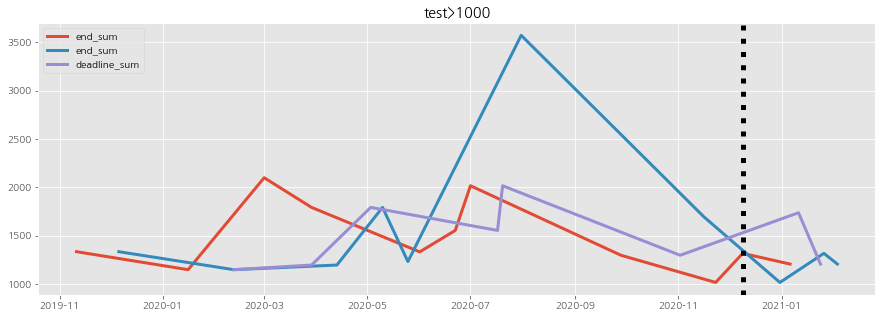

In [25]:
## test 기간 확인
start = top_competition[['period_start','participants']]
start_sum = start.groupby('period_start').sum().reset_index()
start_sum = start_sum[start_sum.participants>1000].reset_index(drop = True)

end = top_competition[['period_end','participants']]
end_sum = end.groupby('period_end').sum().reset_index()
end_sum = end_sum[end_sum.participants>1000].reset_index(drop = True)

deadline = top_competition[['merge_deadline','participants']]
deadline_sum = deadline.groupby('merge_deadline').sum().reset_index()
deadline_sum = deadline_sum[deadline_sum.participants>1000].reset_index(drop = True)

## train 데이터의 연말 연초(사용자, 세션, 신규방문자)
plt.figure(figsize = (15,5))
plt.plot(start_sum.period_start, start_sum.participants, linewidth=3, label = 'end_sum')
plt.plot(end_sum.period_end, end_sum.participants, linewidth=3, label = 'end_sum')
plt.plot(deadline_sum.merge_deadline, deadline_sum.participants, linewidth=3, label = 'deadline_sum')
plt.axvline(x=date(2020,12,9), color='black', linewidth=5, linestyle=':')
plt.legend(loc='upper left')
plt.title('test>1000')
plt.show()

#### 공휴일 데이터 추가

In [26]:
## 공휴일 데이터 생성
date="""2018-09-23, 2018-09-24, 2018-09-25, 2018-09-26, 2018-10-03, 2018-10-09, 2018-12-25, 2019-01-01, 2019-02-04, 2019-02-05, 2019-02-06, 2019-03-01, 2019-05-05, 2019-05-06, 2019-05-12, 2019-06-06, 2019-07-17, 2019-08-15, 2019-09-12, 2019-09-13, 2019-09-14, 2019-10-03, 2019-10-09, 2019-12-25, 2020-01-01, 2020-01-24, 2020-01-25, 2020-01-26, 2020-01-27, 2020-03-01, 2020-04-15, 2020-04-30, 2020-05-05, 2020-06-06, 2020-07-17, 2020-08-15, 2020-08-17, 2020-09-30, 2020-10-01, 2020-10-02, 2020-10-03, 2020-10-09, 2020-12-25, 2021-01-01"""
name="""추석, 추석, 추석, 대체휴무일, 개천절, 한글날, 기독탄신일, 1월1일, 설날, 설날, 설날, 삼일절, 어린이날, 대체공휴일, 부처님오신날, 현충일, 제헌절, 광복절, 추석, 추석, 추석, 개천절, 한글날, 기독탄신일, 1월1일, 설날, 설날, 설날, 설날, 삼일절, 제21대 국회의원선거, 부처님오신날, 어린이날, 현충일, 제헌절, 광복절, 임시공휴일, 추석, 추석, 추석, 개천절, 한글날, 기독탄신일, 1월1일"""

date=date.split(',')
name=name.split(',')
holidays=pd.DataFrame({'date':date,'name':name})
holidays.head()

,date,name
0,2018-09-23,추석
1,2018-09-24,추석
2,2018-09-25,추석
3,2018-09-26,대체휴무일
4,2018-10-03,개천절


In [27]:
# 공휴일 train
train_holidays = train[train['date'].isin(holidays['date'])]

# 일반 train
train_not_holidays = train[~train['date'].isin(holidays['date'])]

#### 주말&휴일과 평일 분리

In [28]:
from datetime import timedelta, date
def daterange(date1, date2):
    for n in range(int ((date2 - date1).days)+1):
        yield date1 + timedelta(n)
        
# train 시작하는 날
start_dt = date(2018,9,9)
# train 끝나는 날 -> new_train을 포함하면서 end_dt를 바꿈
end_dt = date(2020,12,8)

# sub 시작하는 날 -> new_train을 포함하면서 end_dt를 바꿈
start_sub = date(2020,12,9)
# sub 끝나는 날
end_sub = date(2021,1,8)

# 토요일과 일요일
weekdays = [5,6]

# train 정보 저장 : test 데이터로 검정할 때 확인
t_weekday = []
t_weekend = []
for dt in daterange(start_dt, end_dt):
    if dt.weekday() not in weekdays:               
        t_weekday.append(dt.strftime("%Y-%m-%d"))
    else:
        t_weekend.append(dt.strftime("%Y-%m-%d"))


# 제출할 때 적용하기 위함
sub_weekday = []
sub_weekend = []
for dt in daterange(start_sub, end_sub):
    if dt.weekday() not in weekdays:               
        sub_weekday.append(dt.strftime("%Y-%m-%d"))
    else:
        sub_weekend.append(dt.strftime("%Y-%m-%d"))

In [29]:
# train의 주말 연,월,일만 뽑기
train_5day = pd.to_datetime(np.array(t_weekday)).date
train_2day = pd.to_datetime(np.array(t_weekend)).date

# train의 주말 연,월,일만 뽑기
sub_5day = pd.to_datetime(np.array(sub_weekday)).date
sub_2day = pd.to_datetime(np.array(sub_weekend)).date

# submission의 date도 같은 형식으로 뽑기
submission['DateTime'] = pd.to_datetime(submission['DateTime']).dt.date

In [30]:
## train의 주말 연,월,일만 뽑기
train_5day = pd.to_datetime(np.array(t_weekday)).date
train_2day = pd.to_datetime(np.array(t_weekend)).date
holiday_date = pd.to_datetime(np.array(holidays['date'])).date


### 주말 및 공휴일과 평일을 분리하는 함수
    # train
train_holidays['date'] = pd.to_datetime(train_holidays['date'])

# train과 sub의 휴일 분리
t_holidays = holiday_date[holiday_date <= date(2020, 12, 8)]
sub_holidays = holiday_date[holiday_date > date(2020, 12, 8)]
all_train_rest = np.unique(np.sort(np.append(np.array(train_holidays['date'].dt.date), train_2day)))
all_sub_rest = np.sort(np.append(sub_holidays, sub_2day))

def data_rest_distribution(data, date, train_or_sub_date):
    data[date] = pd.to_datetime(data[date]).dt.date
    
    # 분할
    data_rest = data[data[date].isin(train_or_sub_date)]# [['date',col]]
    data_not_rest = data[~data[date].isin(train_or_sub_date)]# [['date',col]]
    
    return data_rest, data_not_rest

### 대회 개수의 영향력 확인
- 일별 진행중인 대회 개수가 다르고 그에 따른 참가자 수 또한 다르다.
- 진행중인 대회 수에 따른 Y의 분포 차이 확인
- 진행되는 대회 수가 많을 수록 Y가 모두 커짐

In [31]:
## 필요한 변수만 남긴 뒤 결측치와 변수 제거
competition = competition_info[['period_start','period_end']].dropna()

# competition

# 각 날짜별 진행되고 있는 대회 개수
# competition 데이터셋의 모든 기간을 포함.

def date_cpt_count(competition):
    from datetime import date, timedelta

    # datatype: datetime으로 변경
    competition['period_start'] =  pd.to_datetime(competition.period_start)
    competition['period_end'] =  pd.to_datetime(competition.period_end)
    # date로 변경
    competition['period_start'] = competition.period_start.dt.date
    competition['period_end'] = competition.period_end.dt.date

    # 모든 대회 기간을 포함하는 datelist 생성. 897개
    start = competition['period_start'].min()
    end = competition['period_end'].max()

    datelist = []
    for i in range((end-start).days +1):
        datelist.append(start+timedelta(days=i))

    # 각 날짜에 대회가 몇개 열렸는지 매칭.
    cpt_cnt = [0 for i in range(len(datelist))] 

    for i in range(len(competition)):
        s = competition.iloc[i]['period_start']
        e = competition.iloc[i]['period_end']
      
        t = 0
        for d in datelist:
            if d >= s and d<=e:
                cpt_cnt[t]+=1
            t+=1

    date_cpt_cnt = pd.DataFrame({'date':datelist
                                ,'count': cpt_cnt})
    date_cpt_cnt.head()

    return date_cpt_cnt

competition = date_cpt_count(competition)

## 대회 개수 변수  추가
train['competition_counts'] = pd.Series(competition[(competition['date']>=date(2018,9,9)) & (competition['date']<=date(2020, 12, 8))].reset_index(drop = True)['count'])
submission['competition_counts'] = pd.Series(competition[(competition['date']>=date(2020,12,9)) & (competition['date']<=date(2021, 1, 8))].reset_index(drop = True)['count'])

#### 1) train 전체 기간으로 본 대회 개수 분포

Text(0, 0.5, 'Competition count')

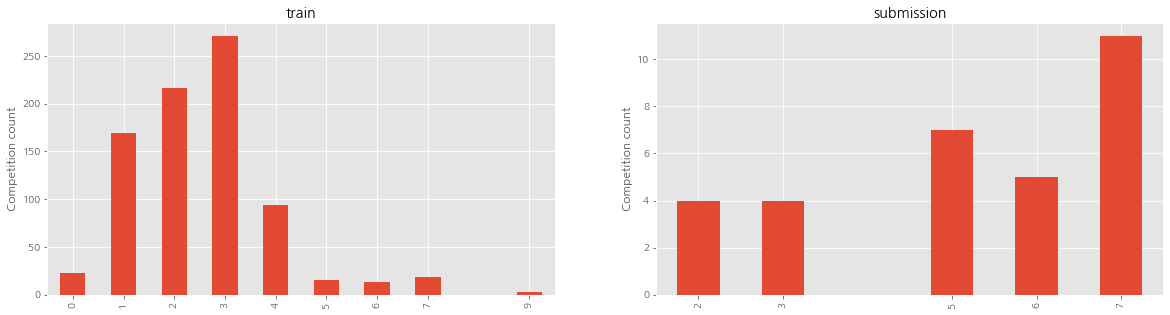

In [32]:
plt.figure(figsize = (20,5))
## 휴일과 평일을 나누지 않은 상태(train)의 대회 수에 따른 분포 확인
plt.subplot(1, 2, 1)
train.competition_counts.value_counts().plot(kind = 'bar')
plt.title('train')
plt.ylabel("Competition count")

## submission 기간 중의 대회 개수 확인
plt.subplot(1, 2, 2)
submission.competition_counts.value_counts().plot(kind = 'bar')
plt.title('submission')
plt.ylabel("Competition count")

Text(0, 0.5, 'Page view count')

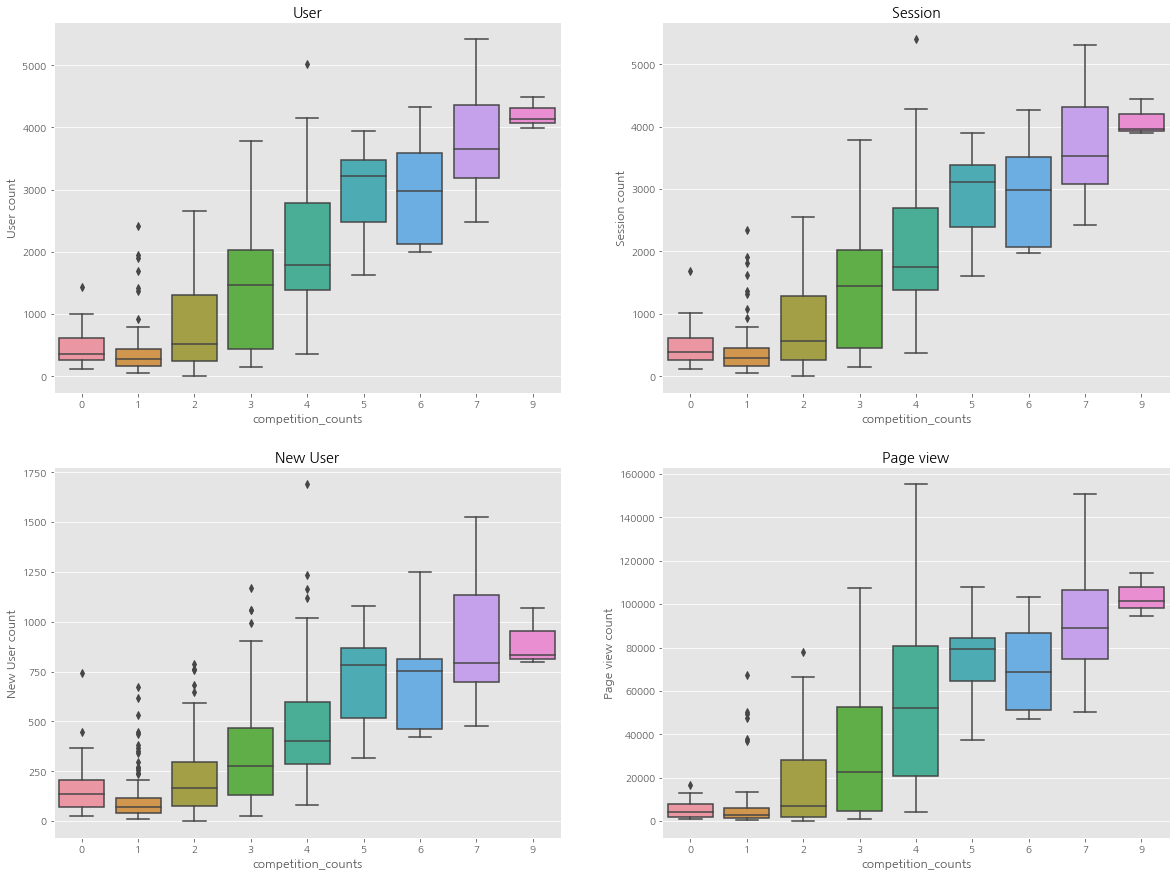

In [33]:
plt.figure(figsize = (20,15))
plt.subplot(2, 2, 1)
sns.boxplot(x = 'competition_counts',
           y = '사용자',
           data = train)
plt.title('User')
plt.ylabel("User count")

plt.subplot(2, 2, 2)
sns.boxplot(x = 'competition_counts',
           y = '세션',
           data = train)
plt.title('Session')
plt.ylabel("Session count")

plt.subplot(2, 2, 3)
sns.boxplot(x = 'competition_counts',
           y = '신규방문자',
           data = train)
plt.title('New User')
plt.ylabel("New User count")

plt.subplot(2, 2, 4)
sns.boxplot(x = 'competition_counts',
           y = '페이지뷰',
           data = train)
plt.title('Page view')
plt.ylabel("Page view count")

#### 2) 휴일의 대회 개수에 따른 분포

In [34]:
## 데이터 분할
train_rest, train_not_rest = data_rest_distribution(train, 'date', all_train_rest)
sub_rest, sub_not_rest = data_rest_distribution(submission, 'DateTime', all_sub_rest)

train_rest = train_rest.set_index('date')
train_not_rest = train_not_rest.set_index('date')
sub_rest = sub_rest.set_index('DateTime')
sub_not_rest = sub_not_rest.set_index('DateTime')

print(train_rest.shape)
print(train_not_rest.shape)
print(sub_rest.shape)
print(sub_not_rest.shape)

(235, 8)
(587, 8)
(10, 5)
(21, 5)


Text(0, 0.5, 'Page view count')

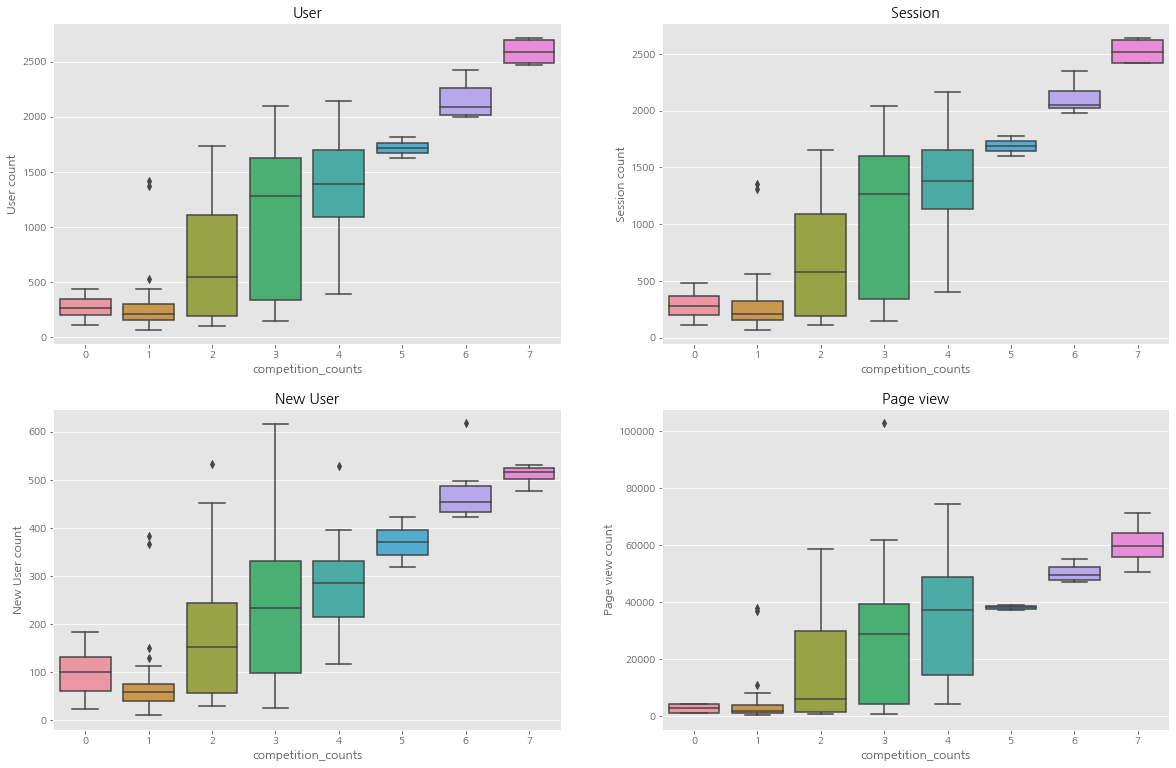

In [36]:
plt.figure(figsize = (20,13))
plt.subplot(2, 2, 1)
sns.boxplot(x = 'competition_counts',
           y = '사용자',
           data = train_rest)
plt.title('User')
plt.ylabel("User count")

plt.subplot(2, 2, 2)
sns.boxplot(x = 'competition_counts',
           y = '세션',
           data = train_rest)
plt.title('Session')
plt.ylabel("Session count")

plt.subplot(2, 2, 3)
sns.boxplot(x = 'competition_counts',
           y = '신규방문자',
           data = train_rest)
plt.title('New User')
plt.ylabel("New User count")

plt.subplot(2, 2, 4)
sns.boxplot(x = 'competition_counts',
           y = '페이지뷰',
           data = train_rest)
plt.title('Page view')
plt.ylabel("Page view count")

#### 3) 평일 대회개수에 따른 분포

Text(0, 0.5, 'Page view count')

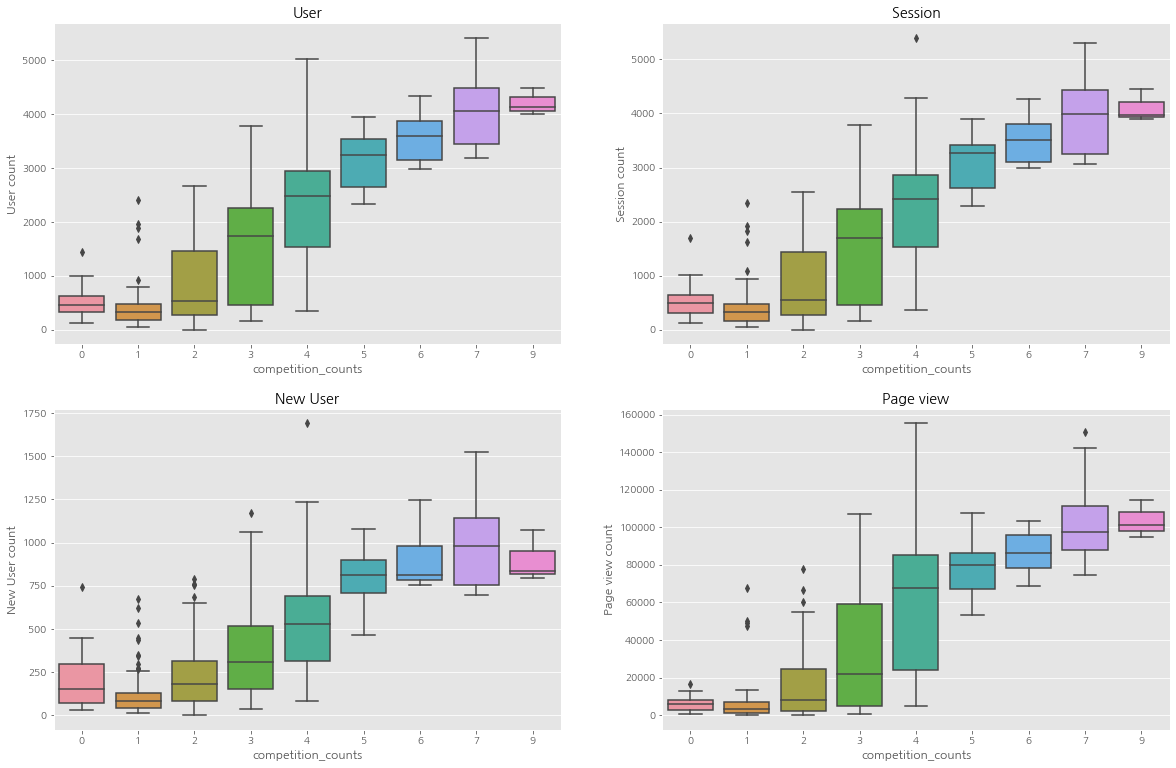

In [35]:
plt.figure(figsize = (20,13))
plt.subplot(2, 2, 1)
sns.boxplot(x = 'competition_counts',
           y = '사용자',
           data = train_not_rest)
plt.title('User')
plt.ylabel("User count")


plt.subplot(2, 2, 2)
sns.boxplot(x = 'competition_counts',
           y = '세션',
           data = train_not_rest)
plt.title('Session')
plt.ylabel("Session count")

plt.subplot(2, 2, 3)
sns.boxplot(x = 'competition_counts',
           y = '신규방문자',
           data = train_not_rest)
plt.title('New User')
plt.ylabel("New User count")

plt.subplot(2, 2, 4)
sns.boxplot(x = 'competition_counts',
           y = '페이지뷰',
           data = train_not_rest)
plt.title('Page view')
plt.ylabel("Page view count")

# 4. LSTM

In [ ]:
train_lstm = train_data.copy()

In [ ]:
# 날짜 관련 변수 생성 및 추가

def create_features(df):
    """
    Creates time series features from datetime index
    """

    df['dayofweek'] = pd.to_datetime(df['date']).dt.dayofweek #요일
    df['quarter'] = pd.to_datetime(df['date']).dt.quarter 
    df['month'] = pd.to_datetime(df['date']).dt.month
    df['year'] = pd.to_datetime(df['date']).dt.year # 날짜의 해당 연도 시작에서부터의 일 수를 반환 
    df['dayofyear'] = pd.to_datetime(df['date']).dt.dayofyear
    df['dayofmonth'] = pd.to_datetime(df['date']).dt.day
    df['weekofyear'] = pd.to_datetime(df['date']).dt.weekofyear
    
    X = df[['사용자','세션','신규방문자','페이지뷰','date','dayofweek','quarter','month','year'
           ,'dayofyear','dayofmonth','weekofyear']]
    X.set_index('date', inplace = True)
    X.index = pd.to_datetime(X.index)
    
    return X

train_lstm = create_features(train_lstm)
train_lstm.head()

,사용자,세션,신규방문자,페이지뷰,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
date,,,,,,,,,,,
2018-09-09,281,266,73,1826,6,3,9,2018,252,9,36
2018-09-10,264,247,51,2092,0,3,9,2018,253,10,37
2018-09-11,329,310,58,1998,1,3,9,2018,254,11,37
2018-09-12,300,287,45,2595,2,3,9,2018,255,12,37
2018-09-13,378,344,50,3845,3,3,9,2018,256,13,37


In [ ]:
holidays['holiday']=1
holidays.set_index('date', inplace = True)
holidays.index = pd.to_datetime(holidays.index)

train_lstm.insert(4, 'holiday', holidays['holiday'])
train_lstm = train_lstm.fillna(0)

# date가 공휴일인 경우에 페이지뷰의 수를 10% 감소시키기 

for i, value in enumerate(train_lstm['holiday']):
    if value==1:
    train_lstm['페이지뷰'][i]= train_lstm['페이지뷰'][i] - (train_lstm['페이지뷰'][i]*0.1)  

train_lstm = train_lstm.drop(['holiday'],axis=1)

- 범주형 인코딩

In [ ]:
# bianry encoding
encoder = ce.BinaryEncoder(cols=['dayofyear'])
train_lstm = encoder.fit_transform(train_lstm)

encoder = ce.BinaryEncoder(cols=['dayofmonth'])
train_lstm = encoder.fit_transform(train_lstm)

encoder = ce.BinaryEncoder(cols=['weekofyear'])
train_lstm = encoder.fit_transform(train_lstm)

In [ ]:
# one-hot encoding

def dummy_data(data, columns):
    for column in columns:
        data = pd.concat([data, pd.get_dummies(data[column], prefix = column)], axis=1)
        data = data.drop(column, axis=1)
    return data


dummy_columns = ["dayofweek", "quarter", "month", "year"]
train_lstm = dummy_data(train_lstm,dummy_columns)

print(train_lstm.shape)
train_lstm.head(3)

(822, 53)


,사용자,세션,신규방문자,페이지뷰,dayofyear_0,dayofyear_1,dayofyear_2,dayofyear_3,dayofyear_4,dayofyear_5,dayofyear_6,dayofyear_7,dayofyear_8,dayofyear_9,dayofmonth_0,dayofmonth_1,dayofmonth_2,dayofmonth_3,dayofmonth_4,dayofmonth_5,weekofyear_0,weekofyear_1,weekofyear_2,weekofyear_3,weekofyear_4,weekofyear_5,weekofyear_6,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,quarter_1,quarter_2,quarter_3,quarter_4,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,year_2018,year_2019,year_2020
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-09-09,281,266,73,1826,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
2018-09-10,264,247,51,2092,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
2018-09-11,329,310,58,1998,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0


In [ ]:
### scaling
mini = train_lstm.iloc[:,:4].min()
size = train_lstm.iloc[:,:4].max() - train_lstm.iloc[:,:4].min()
train_lstm.iloc[:,:4] = (train_lstm.iloc[:,:4] -  mini) / size
train_lstm.head()

,사용자,세션,신규방문자,페이지뷰,dayofyear_0,dayofyear_1,dayofyear_2,dayofyear_3,dayofyear_4,dayofyear_5,dayofyear_6,dayofyear_7,dayofyear_8,dayofyear_9,dayofmonth_0,dayofmonth_1,dayofmonth_2,dayofmonth_3,dayofmonth_4,dayofmonth_5,weekofyear_0,weekofyear_1,weekofyear_2,weekofyear_3,weekofyear_4,weekofyear_5,weekofyear_6,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,quarter_1,quarter_2,quarter_3,quarter_4,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,year_2018,year_2019,year_2020
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-09-09,0.051689,0.049083,0.042604,0.011735,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
2018-09-10,0.048551,0.045564,0.029586,0.013446,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
2018-09-11,0.060550,0.057233,0.033728,0.012842,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
2018-09-12,0.055197,0.052973,0.026036,0.016682,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
2018-09-13,0.069596,0.063530,0.028994,0.024724,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0


In [ ]:
input_window = 61
output_window = 61 # 7

window_x = np.zeros((train_lstm.shape[0] - (input_window + output_window), input_window, 53))
window_y = np.zeros((train_lstm.shape[0] - (input_window + output_window), output_window, 4))

for start in range(train_lstm.shape[0] - (input_window + output_window)):
    end = start + input_window    
    window_x[start,:, :] = train_lstm.iloc[start : end                , : ].values
    window_y[start,:, :] = train_lstm.iloc[end   : end + output_window, :4 ].values


print('window_x.shape: ', window_x.shape)
print('window_y.shape: ', window_y.shape)

window_x.shape:  (700, 61, 53)
window_y.shape:  (700, 61, 4)


In [ ]:
tf.random.set_seed(40)


model = Sequential()
model.add(LSTM(32, input_shape=(61, 53), return_sequences=True))  # (timestep, features)
model.add(LSTM(32, return_sequences=True)) 
model.add(LSTM(32, return_sequences=True)) 
model.add(TimeDistributed(Dense(4)))

opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='mean_squared_error', optimizer=opt)

model.fit(window_x, window_y, epochs=100, batch_size=50)

Epoch 1/100
14/14 [==============================] - 4s 56ms/step - loss: 0.0436
Epoch 2/100
14/14 [==============================] - 1s 58ms/step - loss: 0.0112
Epoch 3/100
14/14 [==============================] - 1s 57ms/step - loss: 0.0085
Epoch 4/100
14/14 [==============================] - 1s 56ms/step - loss: 0.0073
Epoch 5/100
14/14 [==============================] - 1s 57ms/step - loss: 0.0064
Epoch 6/100
14/14 [==============================] - 1s 56ms/step - loss: 0.0055
Epoch 7/100
14/14 [==============================] - 1s 56ms/step - loss: 0.0045
Epoch 8/100
14/14 [==============================] - 1s 61ms/step - loss: 0.0039
Epoch 9/100
14/14 [==============================] - 1s 58ms/step - loss: 0.0035
Epoch 10/100
14/14 [==============================] - 1s 58ms/step - loss: 0.0034
Epoch 11/100
14/14 [==============================] - 1s 56ms/step - loss: 0.0029
Epoch 12/100
14/14 [==============================] - 1s 56ms/step - loss: 0.0026
Epoch 13/100
14/14 [=====

In [ ]:
last_df = train_lstm.iloc[-61:,:].values[np.newaxis,...] 
lstm_pred = model.predict(last_df)

lstm_pred = lstm_pred.reshape(output_window,4)
lstm_pred = lstm_pred * size[:4].values + mini[:4].values
lstm_pred = lstm_pred.astype(int)
lstm_pred = lstm_pred[:31]
lstm_pred

array([[  2186,   2147,    490,  53605],
       [  3065,   3035,    761,  71873],
       [  3682,   3573,    957, 101012],
       [  2105,   2018,    484,  49675],
       [  2007,   1956,    429,  47148],
       [  3382,   3325,    816,  89366],
       [  2937,   2868,    694,  77382],
       [  3437,   3379,    817,  91721],
       [  3312,   3262,    781,  80183],
       [  3155,   3145,    787,  75434],
       [  2046,   2065,    552,  45086],
       [  2108,   2155,    537,  50554],
       [  3697,   3743,   1040, 104187],
       [  2632,   2612,    602,  66276],
       [  2566,   2600,    636,  61461],
       [  2961,   3017,    829,  68332],
       [  2973,   3013,    837,  76922],
       [  1563,   1586,    437,  33327],
       [  1458,   1527,    405,  32977],
       [  2815,   2907,    773,  73740],
       [  2485,   2558,    688,  67564],
       [  2073,   2181,    580,  55033],
       [  2529,   2703,    724,  68668],
       [  2051,   2215,    632,  56342],
       [  1955, 

In [ ]:
lstm_result = pd.DataFrame(lstm_pred) 
lstm_result=lstm_result.rename({0:"사용자",1:"세션",2:"신규방문자",3:"페이지뷰"},axis="columns") 
lstm_result.set_index(submission['DateTime'], inplace=True)
lstm_result

,사용자,세션,신규방문자,페이지뷰
DateTime,,,,
2020-12-09,2186,2147,490,53605
2020-12-10,3065,3035,761,71873
2020-12-11,3682,3573,957,101012
2020-12-12,2105,2018,484,49675
2020-12-13,2007,1956,429,47148
2020-12-14,3382,3325,816,89366
2020-12-15,2937,2868,694,77382
2020-12-16,3437,3379,817,91721
2020-12-17,3312,3262,781,80183


# 5. XGBOOST
- 평일과 휴일 분리 + 대회 개수에 따른 분리 XGB 적용
- 휴일의 경우 : [0,1,2], [3,4,5,6,7]
- 주중의  경우 : [0,1,2], [3,4,5,6,7]

In [37]:
## EDA를 통해 파악하여 휴일과 같은 패턴을 보이는 날들 공휴일에 추가
holidays.reset_index(inplace = True)
holidays['date'] = pd.to_datetime(holidays['date']).dt.date
holidays = holidays.append({'date' : date(2019,5,2), 'name':'연휴'}, ignore_index = True)
holidays = holidays.append({'date' : date(2019,5,3), 'name':'연휴'}, ignore_index = True)
holidays = holidays.append({'date' : date(2020,5,7), 'name':'연휴'}, ignore_index = True)
holidays = holidays.append({'date' : date(2020,5,4), 'name':'연휴'}, ignore_index = True)
holidays = holidays.append({'date' : date(2020,5,1), 'name':'연휴'}, ignore_index = True)
holidays = holidays.append({'date' : date(2019,12,31), 'name':'연말'}, ignore_index = True)
holidays = holidays.append({'date' : date(2020,12,31), 'name':'연말'}, ignore_index = True)

In [38]:
## train의 주말 연,월,일만 뽑기
train_5day = pd.to_datetime(np.array(t_weekday)).date
train_2day = pd.to_datetime(np.array(t_weekend)).date
holiday_date = pd.to_datetime(np.array(holidays['date'])).date

# train의 주말 연,월,일만 뽑기
train_5day = pd.to_datetime(np.array(t_weekday)).date
train_2day = pd.to_datetime(np.array(t_weekend)).date

# train의 주말 연,월,일만 뽑기
sub_5day = pd.to_datetime(np.array(sub_weekday)).date
sub_2day = pd.to_datetime(np.array(sub_weekend)).date

# submission의 date도 같은 형식으로 뽑기
submission['DateTime'] = pd.to_datetime(submission['DateTime']).dt.date

# 공휴일 train
train_holidays = train[train['date'].isin(holidays['date'])]
# 일반 train
train_not_holidays = train[~train['date'].isin(holidays['date'])]


################ 주말 및 공휴일과 평일을 분리하는 함수 ###################
    # train
train_holidays['date'] = pd.to_datetime(train_holidays['date'])

# train과 sub의 휴일 분리
t_holidays = holiday_date[holiday_date <= date(2020, 12, 8)]
sub_holidays = holiday_date[holiday_date > date(2020, 12, 8)]
all_train_rest = np.unique(np.sort(np.append(np.array(train_holidays['date'].dt.date), train_2day)))
all_sub_rest = np.sort(np.append(sub_holidays, sub_2day))

def data_rest_distribution(data, date, train_or_sub_date):
    data[date] = pd.to_datetime(data[date]).dt.date
    
    # 분할
    data_rest = data[data[date].isin(train_or_sub_date)]# [['date',col]]
    data_not_rest = data[~data[date].isin(train_or_sub_date)]# [['date',col]]
    
    return data_rest, data_not_rest

In [39]:
## 여러 정보를 바탕으로 XGB에는 19년 5월 부터 데이터 사용
## 여러 정보를 바탕으로 XGB에는 19년 5월 부터 데이터 사용
xgb_train = train[(pd.to_datetime(train['date'])>='2019-05-01') & (pd.to_datetime(train['date'])<='2020-12-08')]

In [40]:
## 데이터 분할
# 대회 정보 추가
xgb_train['competition_counts'] = pd.Series(competition[(competition['date']>=date(2018,9,9)) & (competition['date']<=date(2020, 12, 8))].reset_index(drop = True)['count'])
submission['competition_counts'] = pd.Series(competition[(competition['date']>=date(2020,12,9)) & (competition['date']<=date(2021, 1, 8))].reset_index(drop = True)['count'])

# 분할
train_rest, train_not_rest = data_rest_distribution(xgb_train, 'date', all_train_rest)
sub_rest, sub_not_rest = data_rest_distribution(submission, 'DateTime', all_sub_rest)

## 인덱스 제거
train_not_rest.reset_index(drop=True, inplace = True)
train_rest.reset_index(drop=True, inplace = True)
sub_rest.reset_index(drop=True, inplace = True)
sub_not_rest.reset_index(drop=True, inplace = True)

print(train_rest.shape)
print(train_not_rest.shape)
print(sub_rest.shape)
print(sub_not_rest.shape)

(195, 9)
(393, 9)
(11, 6)
(20, 6)


In [41]:
## 사용자 분리 : 휴일
t_user_rest_012 = train_rest[train_rest.competition_counts.isin([0,1,2])][['date','사용자']].reset_index(drop=True)
t_user_rest_34567 = train_rest[train_rest.competition_counts.isin([3,4,5,6,7])][['date','사용자']].reset_index(drop=True)
## 사용자 분리 : 평일
t_user_not_rest_012 = train_not_rest[train_not_rest.competition_counts.isin([0,1,2])][['date','사용자']].reset_index(drop=True)
t_user_not_rest_34567 = train_not_rest[train_not_rest.competition_counts.isin([3,4,5,6,7,9])][['date','사용자']].reset_index(drop=True)


## 세션 분리 : 휴일
t_sess_rest_012 = train_rest[train_rest.competition_counts.isin([0,1,2])][['date','세션']].reset_index(drop=True)
t_sess_rest_34567 = train_rest[train_rest.competition_counts.isin([3,4,5,6,7])][['date','세션']].reset_index(drop=True)
## 세션 분리 : 평일
t_sess_not_rest_012 = train_not_rest[train_not_rest.competition_counts.isin([0,1,2])][['date','세션']].reset_index(drop=True)
t_sess_not_rest_34567 = train_not_rest[train_not_rest.competition_counts.isin([3,4,5,6,7,9])][['date','세션']].reset_index(drop=True)


## 신규방문자 분리 : 휴일
t_new_rest_012 = train_rest[train_rest.competition_counts.isin([0,1,2])][['date','신규방문자']].reset_index(drop=True)
t_new_rest_34567 = train_rest[train_rest.competition_counts.isin([3,4,5,6,7])][['date','신규방문자']].reset_index(drop=True)
## 신규방문자 분리 : 평일
t_new_not_rest_012 = train_not_rest[train_not_rest.competition_counts.isin([0,1,2])][['date','신규방문자']].reset_index(drop=True)
t_new_not_rest_34567 = train_not_rest[train_not_rest.competition_counts.isin([3,4,5,6,7,9])][['date','신규방문자']].reset_index(drop=True)


## 페이지뷰 분리 : 휴일
t_page_rest_012 = train_rest[train_rest.competition_counts.isin([0,1,2])][['date','페이지뷰']].reset_index(drop=True)
t_page_rest_34567 = train_rest[train_rest.competition_counts.isin([3,4,5,6,7])][['date','페이지뷰']].reset_index(drop=True)
## 페이지뷰 분리 : 평일
t_page_not_rest_012 = train_not_rest[train_not_rest.competition_counts.isin([0,1,2])][['date','페이지뷰']].reset_index(drop=True)
t_page_not_rest_34567 = train_not_rest[train_not_rest.competition_counts.isin([3,4,5,6,7,9])][['date','페이지뷰']].reset_index(drop=True)

In [42]:
########################################################################################################################
#################################################### sub 분리 ##########################################################
########################################################################################################################
## 사용자 분리 : 휴일
s_user_rest_012 = sub_rest[sub_rest.competition_counts.isin([0,1,2])][['DateTime','사용자']].reset_index(drop=True)
s_user_rest_34567 = sub_rest[sub_rest.competition_counts.isin([3,4,5,6,7])][['DateTime','사용자']].reset_index(drop=True)
## 사용자 분리 : 평일
s_user_not_rest_012 = sub_not_rest[sub_not_rest.competition_counts.isin([0,1,2])][['DateTime','사용자']].reset_index(drop=True)
s_user_not_rest_34567 = sub_not_rest[sub_not_rest.competition_counts.isin([3,4,5,6,7,9])][['DateTime','사용자']].reset_index(drop=True)


## 세션 분리 : 휴일
s_sess_rest_012 = sub_rest[sub_rest.competition_counts.isin([0,1,2])][['DateTime','세션']].reset_index(drop=True)
s_sess_rest_34567= sub_rest[sub_rest.competition_counts.isin([3,4,5,6,7,9])][['DateTime','세션']].reset_index(drop=True)
## 세션 분리 : 평일
s_sess_not_rest_012 = sub_not_rest[sub_not_rest.competition_counts.isin([0,1,2])][['DateTime','세션']].reset_index(drop=True)
s_sess_not_rest_34567 = sub_not_rest[sub_not_rest.competition_counts.isin([3,4,5,6,7,9])][['DateTime','세션']].reset_index(drop=True)


## 신규방문자 분리 : 휴일
s_new_rest_012 = sub_rest[sub_rest.competition_counts.isin([0,1,2])][['DateTime','신규방문자']].reset_index(drop=True)
s_new_rest_34567 = sub_rest[sub_rest.competition_counts.isin([3,4,5,6,7])][['DateTime','신규방문자']].reset_index(drop=True)
## 신규방문자 분리 : 평일
s_new_not_rest_012 = sub_not_rest[sub_not_rest.competition_counts.isin([0,1,2])][['DateTime','신규방문자']].reset_index(drop=True)
s_new_not_rest_34567 = sub_not_rest[sub_not_rest.competition_counts.isin([3,4,5,6,7,9])][['DateTime','신규방문자']].reset_index(drop=True)


## 페이지뷰 분리 : 휴일
s_page_rest_012 = sub_rest[sub_rest.competition_counts.isin([0,1,2])][['DateTime','페이지뷰']].reset_index(drop=True)
s_page_rest_34567 = sub_rest[sub_rest.competition_counts.isin([3,4,5,6,7])][['DateTime','페이지뷰']].reset_index(drop=True)
## 페이지뷰 분리 : 평일
s_page_not_rest_012 = sub_not_rest[sub_not_rest.competition_counts.isin([0,1,2])][['DateTime','페이지뷰']].reset_index(drop=True)
s_page_not_rest_34567 = sub_not_rest[sub_not_rest.competition_counts.isin([3,4,5,6,7,9])][['DateTime','페이지뷰']].reset_index(drop=True)

- 알고리즘 적용

In [43]:
print('휴일 사용자')
print(t_user_rest_012.shape, t_user_rest_34567.shape)
print('휴일 세션')
print(t_sess_rest_012.shape, t_sess_rest_34567.shape)
print('휴일 신규방문자')
print(t_new_rest_012.shape, t_new_rest_34567.shape)
print('휴일 페이지뷰')
print(t_page_rest_012.shape, t_page_rest_34567.shape, end = '\n\n')
print('주중 사용자')
print(t_user_not_rest_012.shape, t_user_not_rest_34567.shape)
print('주중 세션')
print(t_sess_not_rest_012.shape, t_sess_not_rest_34567.shape)
print('주중 신규방문자')
print(t_new_not_rest_012.shape, t_new_not_rest_34567.shape)
print('주중 페이지뷰')
print(t_page_not_rest_012.shape, t_page_not_rest_34567.shape)

휴일 사용자
(73, 2) (122, 2)
휴일 세션
(73, 2) (122, 2)
휴일 신규방문자
(73, 2) (122, 2)
휴일 페이지뷰
(73, 2) (122, 2)

주중 사용자
(144, 2) (249, 2)
주중 세션
(144, 2) (249, 2)
주중 신규방문자
(144, 2) (249, 2)
주중 페이지뷰
(144, 2) (249, 2)


In [44]:
print('휴일 사용자')
print(s_user_rest_012.shape, s_user_rest_34567.shape)
print('휴일 세션')
print(s_sess_rest_012.shape, s_sess_rest_34567.shape)
print('휴일 신규방문자')
print(s_new_rest_012.shape, s_new_rest_34567.shape)
print('휴일 페이지뷰')
print(s_page_rest_012.shape, s_page_rest_34567.shape, end = '\n\n')
print('주중 사용자')
print(s_user_not_rest_012.shape, s_user_not_rest_34567.shape)
print('주중 세션')
print(s_sess_not_rest_012.shape, s_sess_not_rest_34567.shape)
print('주중 신규방문자')
print(s_new_not_rest_012.shape, s_new_not_rest_34567.shape)
print('주중 페이지뷰')
print(s_page_not_rest_012.shape, s_page_not_rest_34567.shape)

휴일 사용자
(2, 2) (9, 2)
휴일 세션
(2, 2) (9, 2)
휴일 신규방문자
(2, 2) (9, 2)
휴일 페이지뷰
(2, 2) (9, 2)

주중 사용자
(2, 2) (18, 2)
주중 세션
(2, 2) (18, 2)
주중 신규방문자
(2, 2) (18, 2)
주중 페이지뷰
(2, 2) (18, 2)


In [45]:
## time_series로 만들기
def date_to_values(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols = list()
    # 입력 sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
    # 출력 sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
    agg = concat(cols, axis=1)
    if dropnan:
        agg.dropna(inplace=True)
    return agg.values

## 모델 fitting
def xgboost_forcasting(dataname, n_in_size):
    values = list(dataname.iloc[:,1].values)
    data = date_to_values(values, n_in = n_in_size)
    train_x, train_y = data[:,:-1], data[:,-1]
    xgboost = XGBRegressor(objective='reg:squarederror', 
                      n_estimators=1000, 
                      random_state = 40)
    xgboost.fit(train_x, train_y)
    return train_x, xgboost

## 예측 함수
def xgb_prediction(data, data2, model_name, num1, num2, name):
    for i in range(0,num2):
        if i==0:
            first = np.reshape(data[-1], (1,num1))
            pred = model_name.predict(first)
            data2[name][i] = pred
            tt = np.reshape(np.append(data[-1,1:], pred), (1,num1))
        else:
            pred = model_name.predict(tt)
            data2[name][i] = pred
            tt = np.reshape(np.append(tt[-1,1:], pred), (1,num1))

In [46]:
## 휴일 예측
train_x, xgboost = xgboost_forcasting(t_user_rest_012, 60)
xgb_prediction(train_x, s_user_rest_012 ,xgboost, 60, 2, '사용자')
train_x, xgboost = xgboost_forcasting(t_sess_rest_012, 60)
xgb_prediction(train_x, s_sess_rest_012 ,xgboost, 60, 2, '세션')
train_x, xgboost = xgboost_forcasting(t_new_rest_012, 60)
xgb_prediction(train_x, s_new_rest_012 ,xgboost, 60, 2, '신규방문자')
train_x, xgboost = xgboost_forcasting(t_page_rest_012, 60)
xgb_prediction(train_x, s_page_rest_012 ,xgboost, 60, 2, '페이지뷰')


train_x, xgboost = xgboost_forcasting(t_user_rest_34567, 90)
xgb_prediction(train_x, s_user_rest_34567 ,xgboost, 90, 9, '사용자')
train_x, xgboost = xgboost_forcasting(t_sess_rest_34567, 90)
xgb_prediction(train_x, s_sess_rest_34567 ,xgboost, 90, 9, '세션')
train_x, xgboost = xgboost_forcasting(t_new_rest_34567, 90)
xgb_prediction(train_x, s_new_rest_34567 ,xgboost, 90, 9, '신규방문자')
train_x, xgboost = xgboost_forcasting(t_page_rest_34567, 90)
xgb_prediction(train_x, s_page_rest_34567 ,xgboost, 90, 9, '페이지뷰')

In [47]:
## 평일 예측
train_x, xgboost = xgboost_forcasting(t_user_not_rest_012, 100)
xgb_prediction(train_x, s_user_not_rest_012 ,xgboost, 100, 2, '사용자')
train_x, xgboost = xgboost_forcasting(t_sess_not_rest_012, 100)
xgb_prediction(train_x, s_sess_not_rest_012 ,xgboost, 100, 2, '세션')
train_x, xgboost = xgboost_forcasting(t_new_not_rest_012, 100)
xgb_prediction(train_x, s_new_not_rest_012 ,xgboost, 100, 2, '신규방문자')
train_x, xgboost = xgboost_forcasting(t_page_not_rest_012, 100)
xgb_prediction(train_x, s_page_not_rest_012 ,xgboost, 100, 2, '페이지뷰')


train_x, xgboost = xgboost_forcasting(t_user_not_rest_34567, 200)
xgb_prediction(train_x, s_user_not_rest_34567 ,xgboost, 200, 19, '사용자')
train_x, xgboost = xgboost_forcasting(t_sess_not_rest_34567, 200)
xgb_prediction(train_x, s_sess_not_rest_34567 ,xgboost, 200, 19, '세션')
train_x, xgboost = xgboost_forcasting(t_new_not_rest_34567, 200)
xgb_prediction(train_x, s_new_not_rest_34567 ,xgboost, 200, 19, '신규방문자')
train_x, xgboost = xgboost_forcasting(t_page_not_rest_34567, 200)
xgb_prediction(train_x, s_page_not_rest_34567 ,xgboost, 200, 19, '페이지뷰')

In [48]:
df1 = pd.concat([s_user_rest_012, s_sess_rest_012.iloc[:,1], s_new_rest_012.iloc[:,1], s_page_rest_012.iloc[:,1]], axis = 1)
df2 = pd.concat([s_user_rest_34567, s_sess_rest_34567.iloc[:,1], s_new_rest_34567.iloc[:,1], s_page_rest_34567.iloc[:,1]], axis = 1)
df3 = pd.concat([s_user_not_rest_012, s_sess_not_rest_012.iloc[:,1], s_new_not_rest_012.iloc[:,1], s_page_not_rest_012.iloc[:,1]], axis = 1)
df4 = pd.concat([s_user_not_rest_34567, s_sess_not_rest_34567.iloc[:,1], s_new_not_rest_34567.iloc[:,1], s_page_not_rest_34567.iloc[:,1]], axis = 1)

In [49]:
## 예측값 합치기
for i in [df1, df2, df3, df4]:
    i.set_index('DateTime', inplace = True)
    
xgb_result = pd.concat([df1, df2, df3, df4]).sort_index()
print(xgb_result.shape)
xgb_result

(31, 4)


,사용자,세션,신규방문자,페이지뷰
DateTime,,,,
2020-12-09,3033,2990,771,68857
2020-12-10,3201,3410,877,71279
2020-12-11,3285,3608,851,75765
2020-12-12,2119,2077,460,46913
2020-12-13,2476,2360,418,58464
2020-12-14,3288,3881,822,83626
2020-12-15,3222,3781,818,84770
2020-12-16,3372,3686,801,85972
2020-12-17,2994,3253,813,82361


------

# 6. EXTRA TREE

In [50]:
trn = pd.merge(train_data, add_data, how = 'inner', on = 'date')
trn.tail()

,date,사용자,세션,신규방문자,페이지뷰,active_made,active_login_user,all_login_user,active_sub_user,active_sub_team,all_sub_user,all_sub_team
721,2020-12-04,3189,3068,743,75730,42,227,276,136,136,352,352
722,2020-12-05,2055,2019,497,47638,31,129,143,70,74,197,197
723,2020-12-06,2119,2077,460,46914,24,147,169,72,73,192,192
724,2020-12-07,2979,2988,753,77443,70,279,345,113,112,236,236
725,2020-12-08,3033,2990,772,68857,70,265,299,98,100,223,223


#### 데이터 분할
- 이상점을 가지는 날들을 판별하기 위해 extra 알고리즘을 사용
- 19년도 까지는 이상점을 가지는 날이 없을 뿐더러 전체적으로 Y값들이 낮기에 최근 년도인 20년도 데이터만 사용

In [51]:
## 훈련 데이터
trn_x = trn[(trn.date >= date(2020,1,1)) & (trn.date <= date(2020,12,8))].iloc[:,5:]
trn_y_user = trn[(trn.date >= date(2020,1,1)) & (trn.date <= date(2020,12,8))].reset_index(drop = True).iloc[:,1]
trn_y_sess = trn[(trn.date >= date(2020,1,1)) & (trn.date <= date(2020,12,8))].reset_index(drop = True).iloc[:,2]
trn_y_new = trn[(trn.date >= date(2020,1,1)) & (trn.date <= date(2020,12,8))].reset_index(drop = True).iloc[:,3]
trn_y_page = trn[(trn.date >= date(2020,1,1)) & (trn.date <= date(2020,12,8))].reset_index(drop = True).iloc[:,4]

## 테스트 데이터
test_x = add_data[(add_data.date > date(2020,12,8)) & (add_data.date < date(2021, 1, 9))].reset_index(drop = True).iloc[:,1:]

In [52]:
print(trn_x.shape)
print(trn_y_user.shape)
print(test_x.shape)

(343, 7)
(343,)
(31, 7)


In [53]:
## 독립변수 확인
trn_x.head()

,active_made,active_login_user,all_login_user,active_sub_user,active_sub_team,all_sub_user,all_sub_team
383,38,115,169,65,65,174,174
384,97,248,362,84,84,210,210
385,63,179,262,88,88,210,210
386,61,146,206,86,87,191,191
387,50,131,174,94,91,232,232


In [54]:
### Grid Search CV를 통해 발견한 best parameter 설정
## 베스트 파라미터 저장
final_grid1_params = {'max_depth': 9, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 600, 'random_state': 40}
final_grid2_params = {'max_depth': 8, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 700, 'random_state': 40}
final_grid3_params = {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 550, 'random_state': 40}
final_grid4_params = {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 400, 'random_state': 40}

## best 파라미터 입력
final_grid1 = ExtraTreesRegressor(**final_grid1_params)
final_grid2 = ExtraTreesRegressor(**final_grid2_params)
final_grid3 = ExtraTreesRegressor(**final_grid3_params)
final_grid4 = ExtraTreesRegressor(**final_grid4_params)

## 피팅
final_grid1.fit(trn_x, trn_y_user)
final_grid2.fit(trn_x, trn_y_sess)
final_grid3.fit(trn_x, trn_y_new)
final_grid4.fit(trn_x, trn_y_page)

## 예측
pred_user_grid = pd.Series(final_grid1.predict(test_x))
pred_sess_grid = pd.Series(final_grid2.predict(test_x))
pred_new_grid = pd.Series(final_grid3.predict(test_x))
pred_page_grid = pd.Series(final_grid4.predict(test_x))

In [56]:
## 이후 날짜도 합치기
extra_result = pd.concat([submission.DateTime.reset_index(drop=True), pred_user_grid, pred_sess_grid, pred_new_grid, pred_page_grid], axis = 1)
extra_result.set_index('DateTime', inplace = True)
extra_result.rename(columns = {0:'사용자',1:'세션',2:'신규방문자',3:'페이지뷰'}, inplace = True)
extra_result = extra_result.round().astype(int)
extra_result

,사용자,세션,신규방문자,페이지뷰
DateTime,,,,
2020-12-09,3895,3887,1015,103843
2020-12-10,2906,2972,761,58831
2020-12-11,2754,2693,698,67344
2020-12-12,2160,2093,468,52298
2020-12-13,1917,1854,414,45641
2020-12-14,3067,3005,756,77360
2020-12-15,3332,3280,849,81826
2020-12-16,2934,2897,791,70723
2020-12-17,3032,3002,758,74137


----

# 7. Weighted average ensemble
- 알고리즘 결과값들을 비교한 후 각기 다르게 가중치 부여

In [90]:
### DateTime 인덱스 설정
lstm_result.index = pd.to_datetime(lstm_result.index)
xgb_result.index = pd.to_datetime(xgb_result.index)
extra_result.index = pd.to_datetime(extra_result.index)

### 결과값 비교
fig = make_subplots(
    subplot_titles=("사용자","세션","신규방문자","페이지뷰"),
    horizontal_spacing=0.1,
    rows=2, cols=2 )

fig.add_trace(go.Scatter(x=lstm_result.index, y=lstm_result['사용자'],name="lstm_result",
                          marker=dict(size=9, color='Red')), row=1, col=1)
fig.add_trace(go.Scatter(x=xgb_result.index, y=xgb_result['사용자'],name="xgb_result",
                         marker=dict(size=9, color='Green')), row=1, col=1)
fig.add_trace(go.Scatter(x=extra_result.index, y=extra_result['사용자'],name="extra_result",
                         marker=dict(size=9, color='Blue')), row=1, col=1)

fig.add_trace(go.Scatter(x=lstm_result.index, y=lstm_result['세션'],name="lstm_result",
                          marker=dict(size=9, color='Red'),showlegend = False), row=1, col=2)
fig.add_trace(go.Scatter(x=xgb_result.index, y=xgb_result['세션'],name="xgb_result",
                         marker=dict(size=9, color='Green'),showlegend = False), row=1, col=2)
fig.add_trace(go.Scatter(x=extra_result.index, y=extra_result['세션'],name="extra_result",
                         marker=dict(size=9, color='Blue'),showlegend = False), row=1, col=2)

fig.add_trace(go.Scatter(x=lstm_result.index, y=lstm_result['신규방문자'],name="lstm_result",
                          marker=dict(size=9, color='Red'),showlegend = False), row=2, col=1)
fig.add_trace(go.Scatter(x=xgb_result.index, y=xgb_result['신규방문자'],name="xgb_result",
                         marker=dict(size=9, color='Green'),showlegend = False), row=2, col=1)
fig.add_trace(go.Scatter(x=extra_result.index, y=extra_result['신규방문자'],name="extra_result",
                         marker=dict(size=9, color='Blue'),showlegend = False), row=2, col=1)

fig.add_trace(go.Scatter(x=lstm_result.index, y=lstm_result['페이지뷰'],name="lstm_result",
                          marker=dict(size=9, color='Red'),showlegend = False), row=2, col=2)
fig.add_trace(go.Scatter(x=xgb_result.index, y=xgb_result['페이지뷰'],name="xgb_result",
                         marker=dict(size=9, color='Green'),showlegend = False), row=2, col=2)
fig.add_trace(go.Scatter(x=extra_result.index, y=extra_result['페이지뷰'],name="extra_result",
                         marker=dict(size=9, color='Blue'),showlegend = False), row=2, col=2)

fig.update_layout(height =800, width =950, title_text="Scatter Plot for result", template='ggplot2')
fig.show()

In [93]:
final_result = ((lstm_result*0.3)+(xgb_result*0.7))*0.2 + extra_result*0.8
final_result = final_result.astype(int)
final_result

,사용자,세션,신규방문자,페이지뷰
DateTime,,,,
2020-12-09,3671,3657,949,95930
2020-12-10,2956,3037,777,61356
2020-12-11,2884,2873,734,70543
2020-12-12,2150,2086,467,51386
2020-12-13,2000,1930,415,47526
2020-12-14,3116,3146,768,78957
2020-12-15,3292,3325,835,81971
2020-12-16,3025,3036,793,74117
2020-12-17,3043,3052,767,75651


In [95]:
submission = pd.read_csv('data/submission.csv', encoding = 'euc-kr')
submission.DateTime = pd.to_datetime(submission.DateTime).dt.date

for i in range(31):
    submission['사용자'][i+30] = final_result['사용자'][i]
    submission['세션'][i+30] = final_result['세션'][i]
    submission['신규방문자'][i+30] = final_result['신규방문자'][i]
    submission['페이지뷰'][i+30] = final_result['페이지뷰'][i]

submission

,DateTime,사용자,세션,신규방문자,페이지뷰
0,2020-11-09,0,0,0,0
1,2020-11-10,0,0,0,0
2,2020-11-11,0,0,0,0
3,2020-11-12,0,0,0,0
4,2020-11-13,0,0,0,0
...,...,...,...,...,...
56,2021-01-04,3739,3743,994,98859
57,2021-01-05,3673,3612,899,97362
58,2021-01-06,4515,4627,1267,131409
59,2021-01-07,4159,4216,1110,111612


In [ ]:
submission.to_csv('submission.csv', index = False, encoding = 'euc-kr')

In [133]:
add_data.tail(40)

,date,active_made,active_login_user,all_login_user,active_sub_user,active_sub_team,all_sub_user,all_sub_team
717,2020-11-30,62,305,346,170,171,453,453
718,2020-12-01,48,284,339,144,129,522,522
719,2020-12-02,33,255,308,151,141,823,823
720,2020-12-03,43,236,282,123,125,365,365
721,2020-12-04,42,227,276,136,136,352,352
722,2020-12-05,31,129,143,70,74,197,197
723,2020-12-06,24,147,169,72,73,192,192
724,2020-12-07,70,279,345,113,112,236,236
725,2020-12-08,70,265,299,98,100,223,223
726,2020-12-09,81,426,493,97,92,217,217
